In [1]:
import json

import matplotlib.pyplot as plt

from CCAgT_utils.visualization import plot
from CCAgT_utils.categories import CategoriesInfos

In [2]:
metadata_path = '../../data/samples/CCAgT_dataset_metadata.json'
with open(metadata_path, 'r') as hf:
    dataset_info = json.load(hf)
    
cats_info = dataset_info['categories']
ccagt_infos = CategoriesInfos(cats_info)

In [3]:
from CCAgT_utils.types.annotation import BBox

boxes = [BBox(100, 25, 40, 75, 1),
         BBox(300, 1000, 100, 50, 1),
         BBox(800, 25, 50, 50, 1),
         BBox(500, 500, 90, 100, 1),
         BBox(520, 520, 7, 7, 2),
         BBox(565, 565, 5, 5, 3)]

In [4]:
import numpy as np
img = np.zeros((1200, 1600))

## Draw the boxes

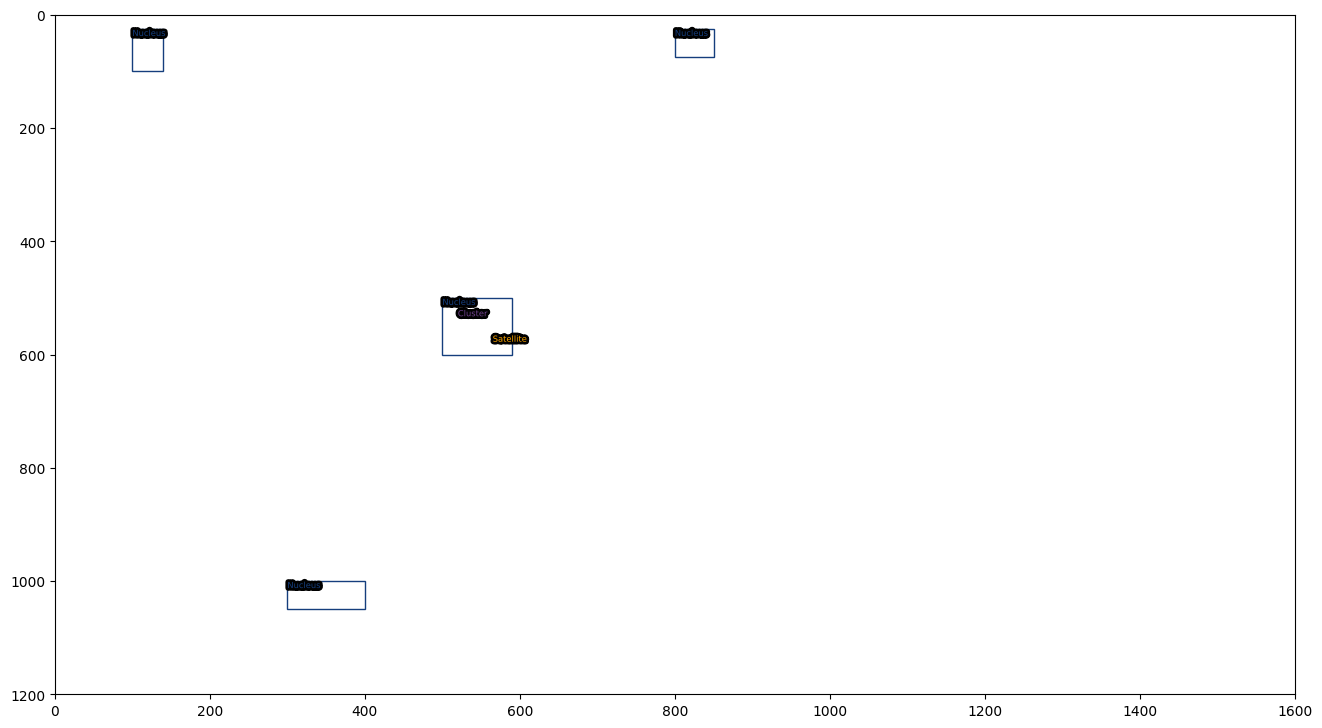

In [5]:
fix, ax = plt.subplots(1, 1,figsize=(16, 9), dpi=100)
ax.set_xlim([0, 1600])
ax.set_ylim([1200, 0])

plot.bbox(boxes, ax, ccagt_infos, fontsize=6, write_names=True)
plt.show()

## Plot image with boxes

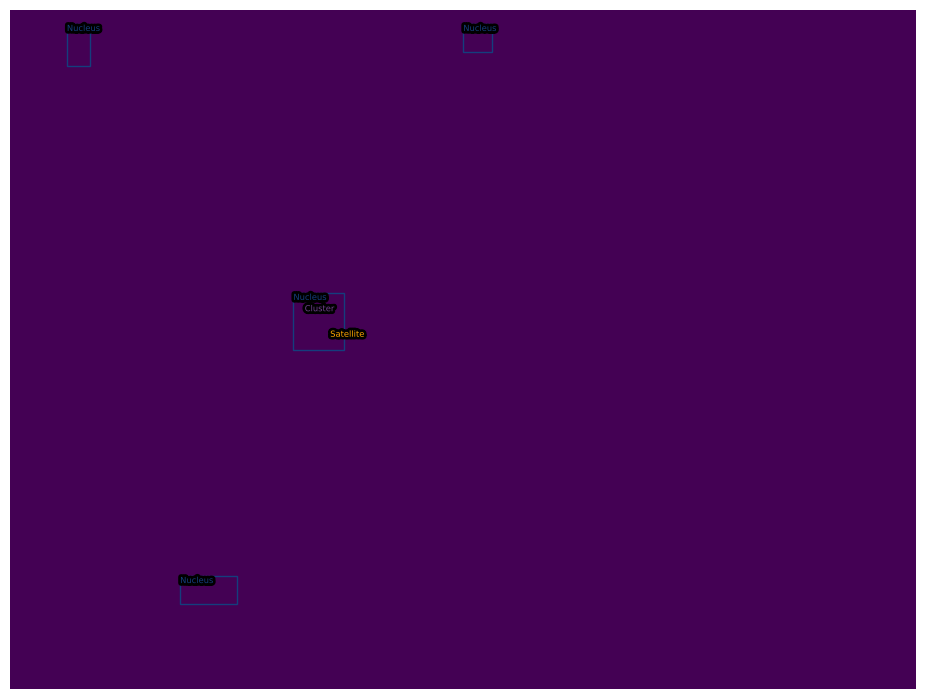

In [6]:
fix, ax = plt.subplots(1, 1,figsize=(16, 9), dpi=100)
plot.image_with_boxes(img, boxes, ax, ccagt_infos, write_names=True, fontsize=6)
plt.show()

### Plot sample image and the boxes

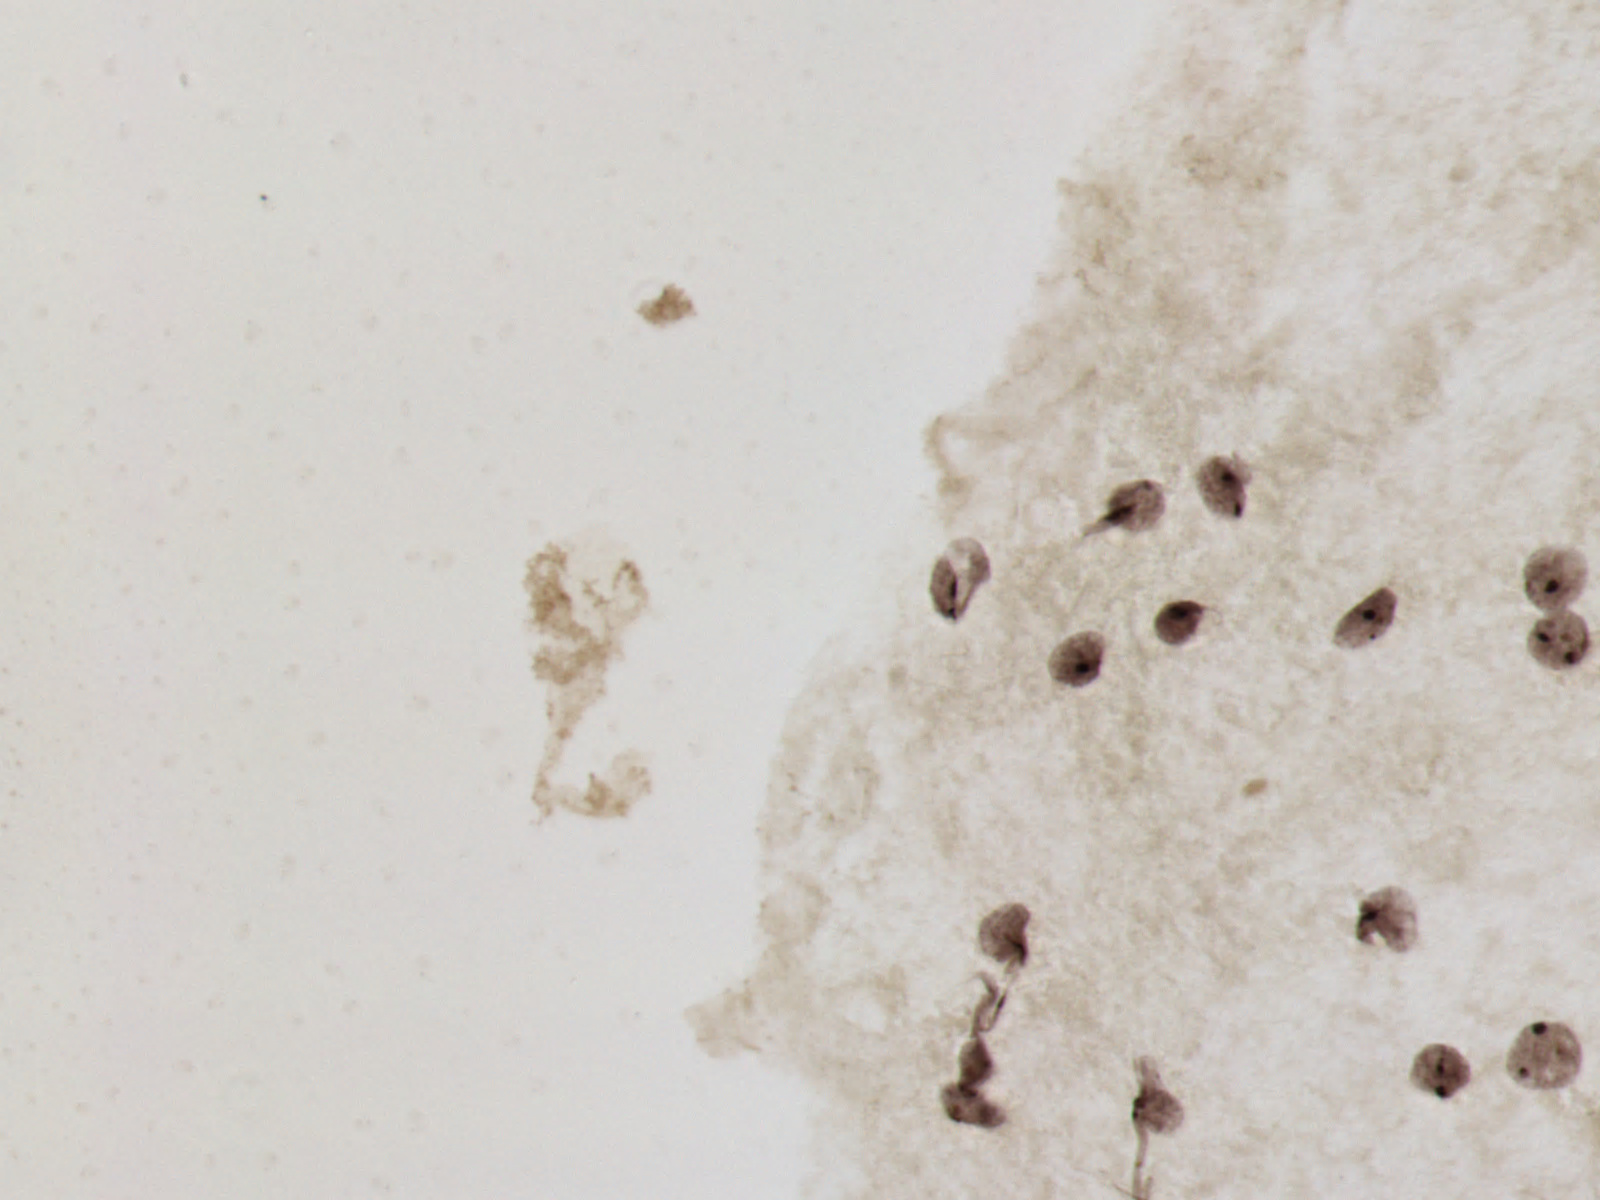

In [7]:
from PIL import Image

image_name = 'C_13509_-270720_116640.jpg'
image_path = f'../../data/samples/images/{image_name}'
img = Image.open(image_path)
img

#### load the annotations into the right format

In [8]:
from CCAgT_utils.converters import LabelBox
labelbox_raw_path = '../../data/samples/sanitized_sample_labelbox.json'

with open(labelbox_raw_path) as f:
    labelbox_raw =  json.load(f)

lb_ann = LabelBox.LabelBox(labelbox_raw, cats_info)

CCAgT_ann = lb_ann.to_CCAgT()

df = CCAgT_ann.df
df['geo_type'] = CCAgT_ann.geometries_type()

In [9]:
sat_series = df.loc[(df['category_id']==3) & (df['geo_type']=='Point'), 'geometry']

df.loc[(df['category_id']==3) & (df['geo_type']=='Point'), 'geometry'] = CCAgT_ann.satellite_point_to_polygon(sat_series)

df['geo_type'] = CCAgT_ann.geometries_type()

df['geometry'] = CCAgT_ann.fit_geometries_to_image_boundary()

In [10]:
from CCAgT_utils.types.annotation import bounds_to_BBox

In [11]:
image_boxes = df[df['image_name'] == image_name.replace('.jpg', '')].apply(lambda r: bounds_to_BBox(r['geometry'].bounds, r['category_id']),
                                                             axis=1).to_numpy().tolist()

In [12]:
image_boxes[:2], len(image_boxes)

([BBox(x_init=1197, y_init=455, width=50, height=64, category_id=1),
  BBox(x_init=1409, y_init=1042, width=61, height=58, category_id=1)],
 27)

#### plot image with boxes

In [13]:
handles = plot.create_handles(ccagt_infos)

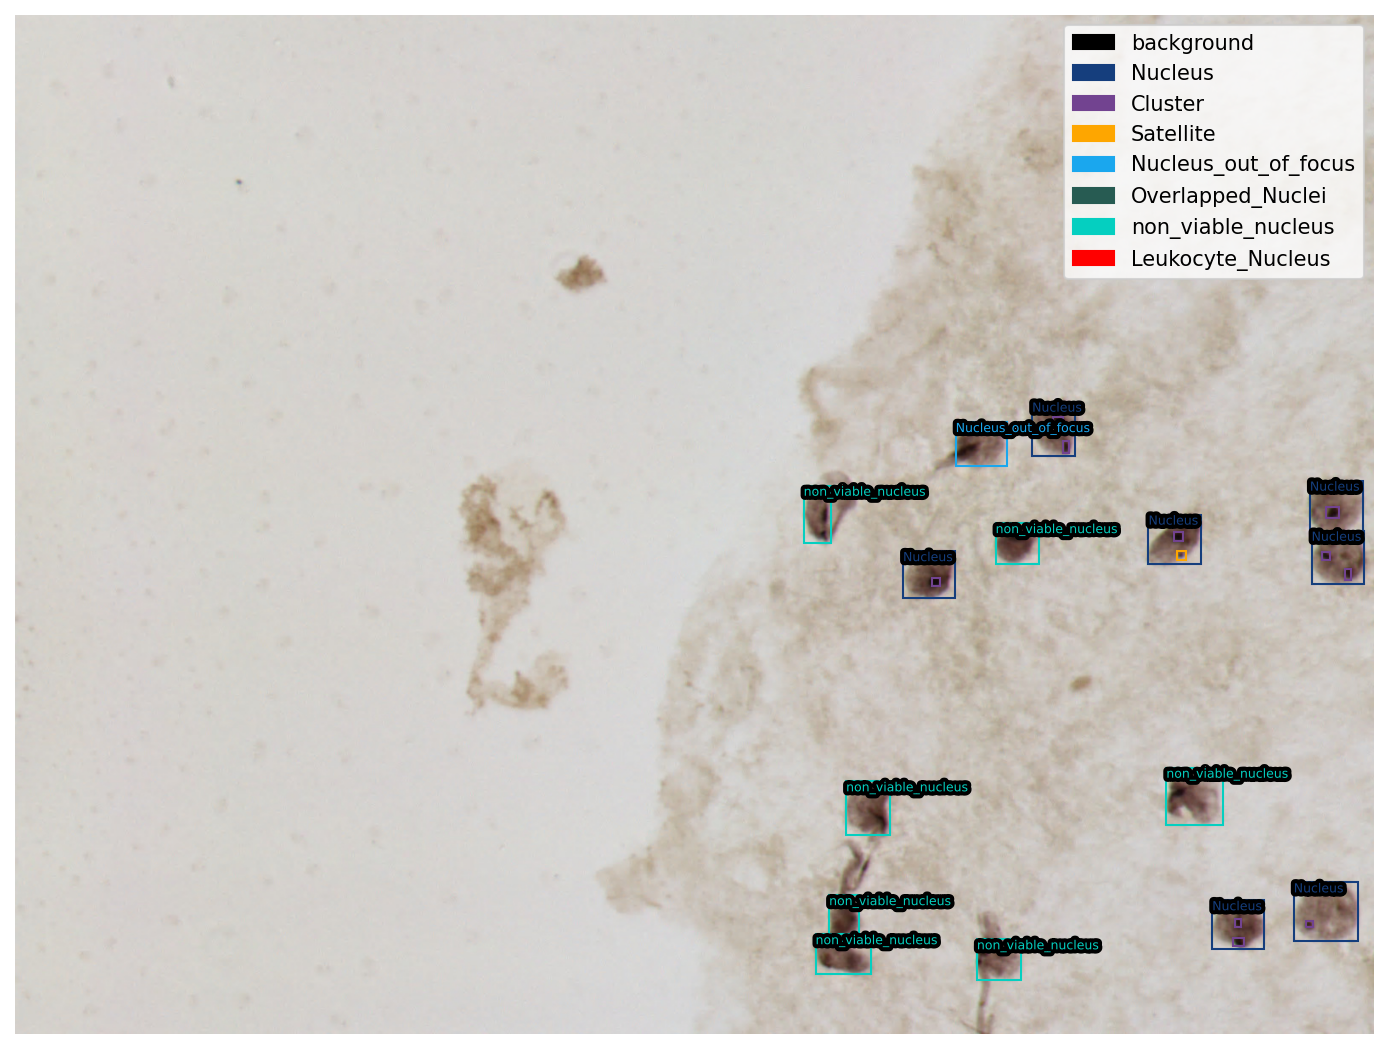

In [14]:
fix, ax = plt.subplots(1, 1,figsize=(16, 9), dpi=150)
plot.image_with_boxes(img, image_boxes, ax, ccagt_infos, write_names=True, fontsize=6, without_text={2,3})
ax.legend(handles=handles)
plt.show()

## Plot a image and a mask

In [15]:
from CCAgT_utils.types.mask import Mask

msk = np.zeros((1200, 1600))
msk[300:600, 300:700] = 1
msk[300:600, 710:1100] = 2
msk[300:600, 1110:1500] = 3
msk[590:900, 1110:1500] = 4
msk[650:750, 1250:1400] = 2
msk[590:900, 710:1100] = 5
msk[590:900, 300:700] = 6
msk[910:1200, 300:700] = 7
msk = Mask(msk)

In [16]:
handles = plot.create_handles(ccagt_infos, msk.unique_ids)

In [17]:
[c.color for c in ccagt_infos]

[Color(Red=21, Green=62, Blue=125, Alpha=255, size=8),
 Color(Red=114, Green=67, Blue=144, Alpha=255, size=8),
 Color(Red=254, Green=166, Blue=0, Alpha=255, size=8),
 Color(Red=26, Green=167, Blue=238, Alpha=255, size=8),
 Color(Red=39, Green=91, Blue=82, Alpha=255, size=8),
 Color(Red=5, Green=207, Blue=192, Alpha=255, size=8),
 Color(Red=255, Green=0, Blue=0, Alpha=255, size=8),
 Color(Red=0, Green=0, Blue=0, Alpha=255, size=8)]

In [18]:
msk

Mask(categorical=array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))

### Plotting a just a mask with cmap

Need to use the `vmax` and `vmin` to guarantee the correct usage of the `cmap` in general cases. Meanwhile, the `cmap` is personalized for each mask (just put the needed colors), so *maybe* this is not necessary more. And need to use the `interpolation='nearest'` because of border effect in the colorized objects.

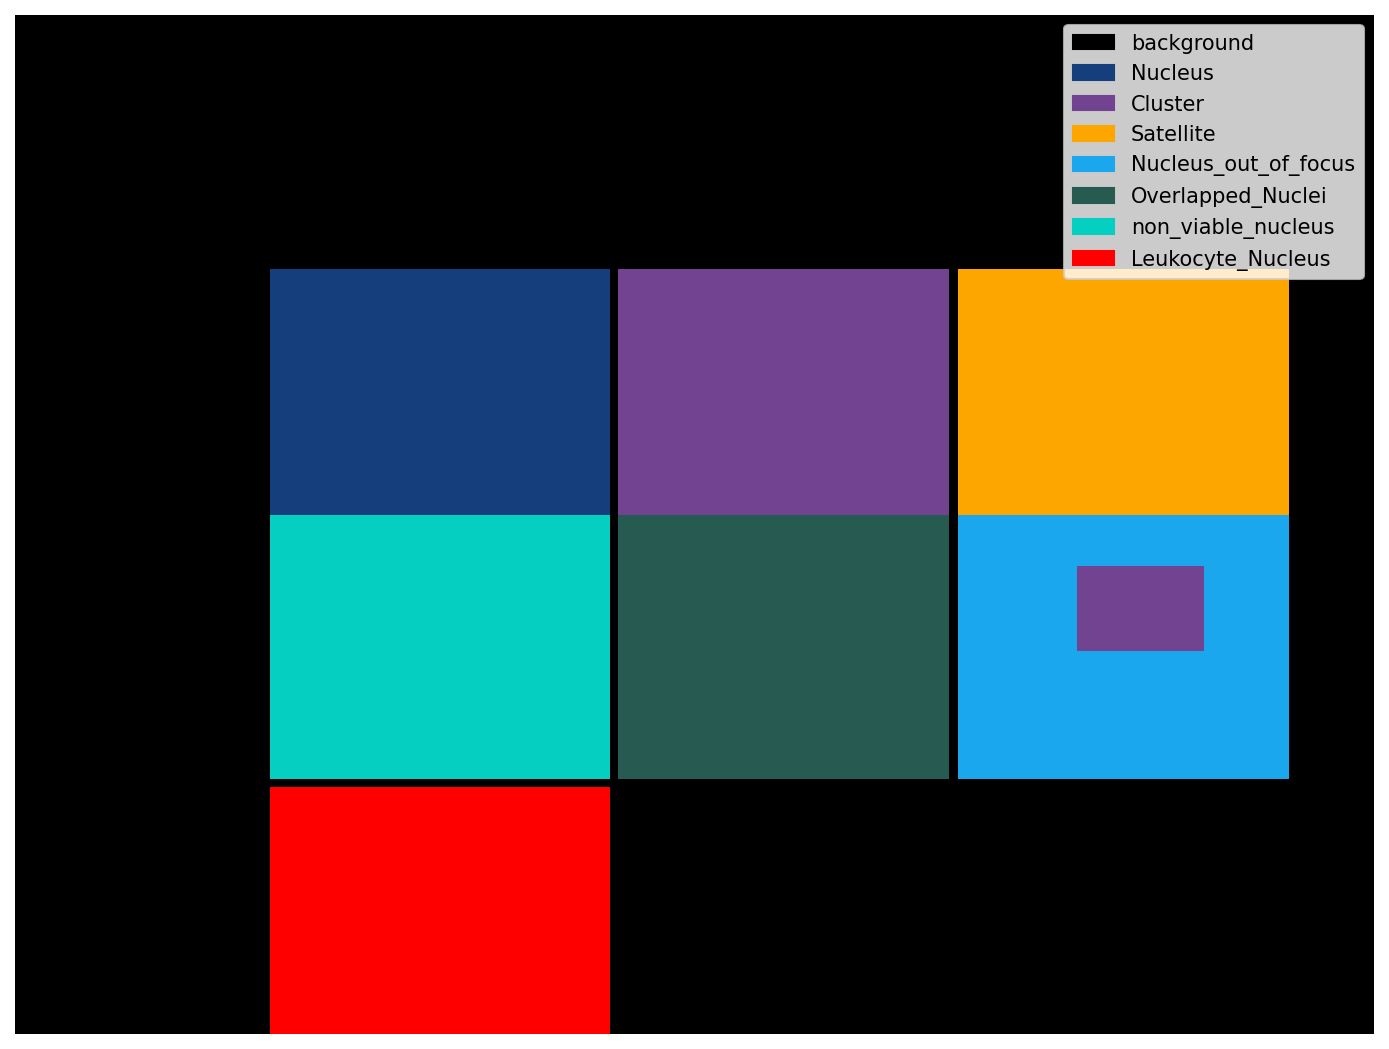

In [19]:
fix, ax = plt.subplots(1, 1,figsize=(16, 9), dpi=150)
ax.imshow(msk.categorical,
          cmap=msk.cmap(ccagt_infos),
          vmax=max(msk.unique_ids),
          vmin=min(msk.unique_ids),
          interpolation= 'nearest')
ax.legend(handles=handles)
ax.set_axis_off()
plt.show()

### Just plotting a mask with categorical to colorized mask

In [20]:
msk_rgb = msk.colorized(ccagt_infos)
msk_rgb

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

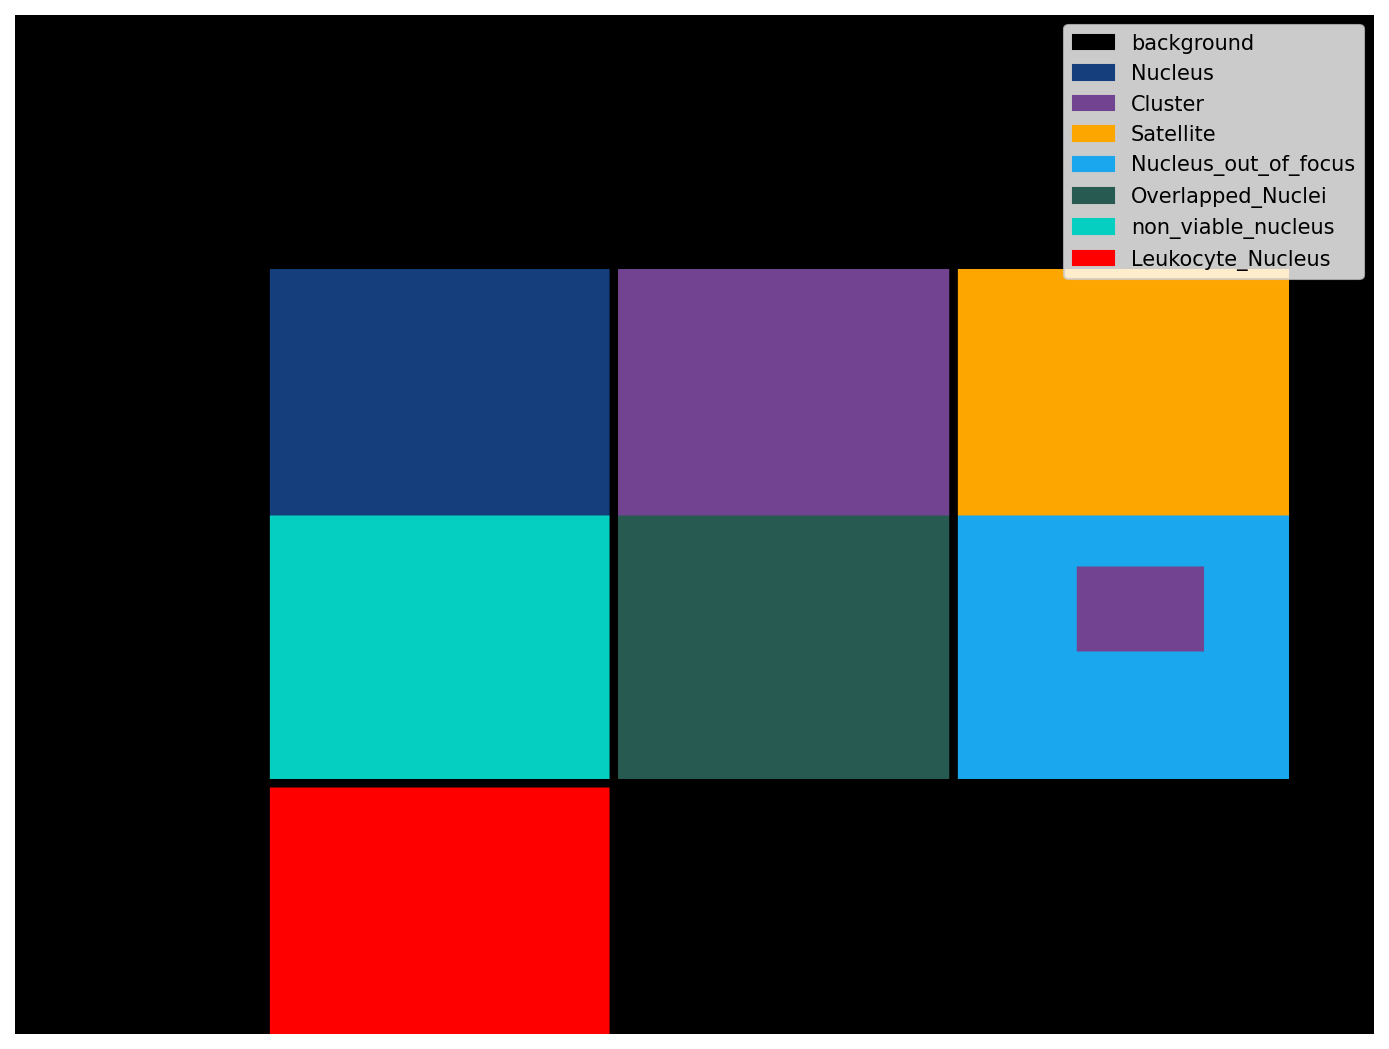

In [21]:
fix, ax = plt.subplots(1, 1,figsize=(16, 9), dpi=150)
ax.imshow(msk_rgb)
ax.legend(handles=handles)
ax.set_axis_off()
plt.show()

### Comparing approaches: cmap vs colorized images

Categorical mask: a 2D matrix
Colorized image: a 3D matrix (an RGB image)

If use CMAP:
- Need to create a personalized CMAP for each mask
- Need to set more parameters at `imshow` (`vmax`, `vmin` and `interpolation`)
- Can have unwanted effects at the colors of borders objects because of matplotlib interpolation calculus.

If use colorized images
- Will need to compute a new RGB image based on the categorical mask

So, using just `cmap` approach will be less computationally expensive (don't need to create an RGB image), but can present unwanted effects at the colors of borders objects.


Can use the `plot.mask_with_color` by default will plot using the cmap approach, if pass as argument `colorized=True` will use the colorized image approach.

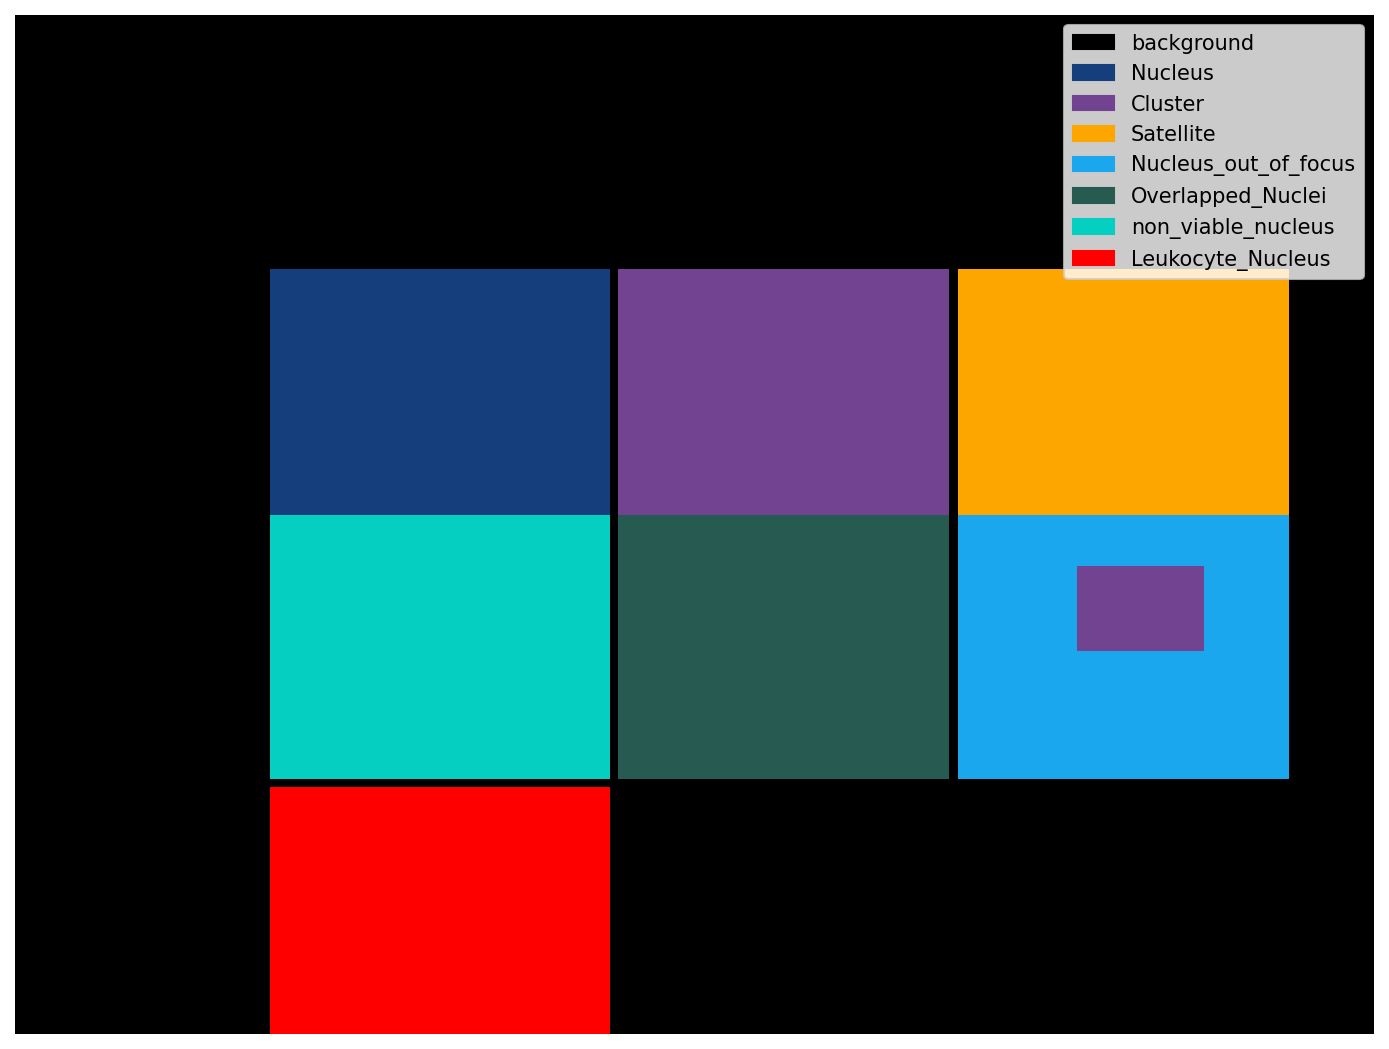

In [22]:
fix, ax = plt.subplots(1, 1,figsize=(16, 9), dpi=150)
plot.mask_with_color(msk, ax, ccagt_infos, colorized=False)
ax.legend(handles=handles)
plt.show()

### Plotting a image with a mask as overlay

In [23]:
# put the background as invisible (setting alpha channel as 0)

from CCAgT_utils.types.colors import Color

ccagt_infos[0].color = Color(0, 0, 0, 0)


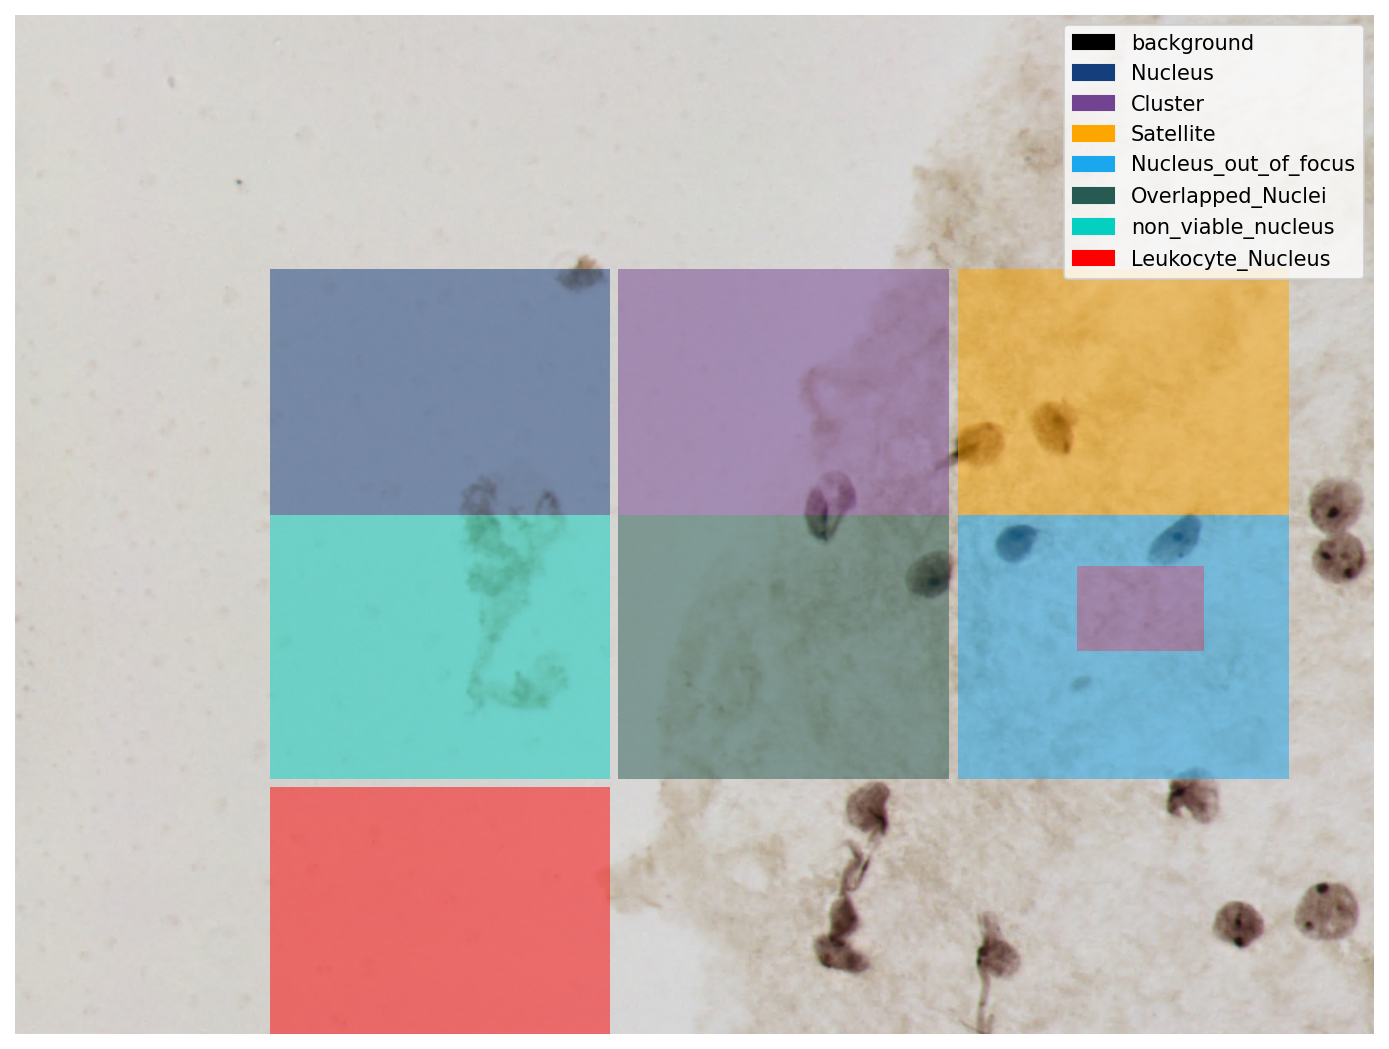

In [24]:
fix, ax = plt.subplots(1, 1,figsize=(16, 9), dpi=150)
ax.imshow(img)
plot.mask_with_color(msk, ax, ccagt_infos, colorized=False, alpha= .5)
ax.legend(handles=handles)
plt.show()

### A plot for comparing results

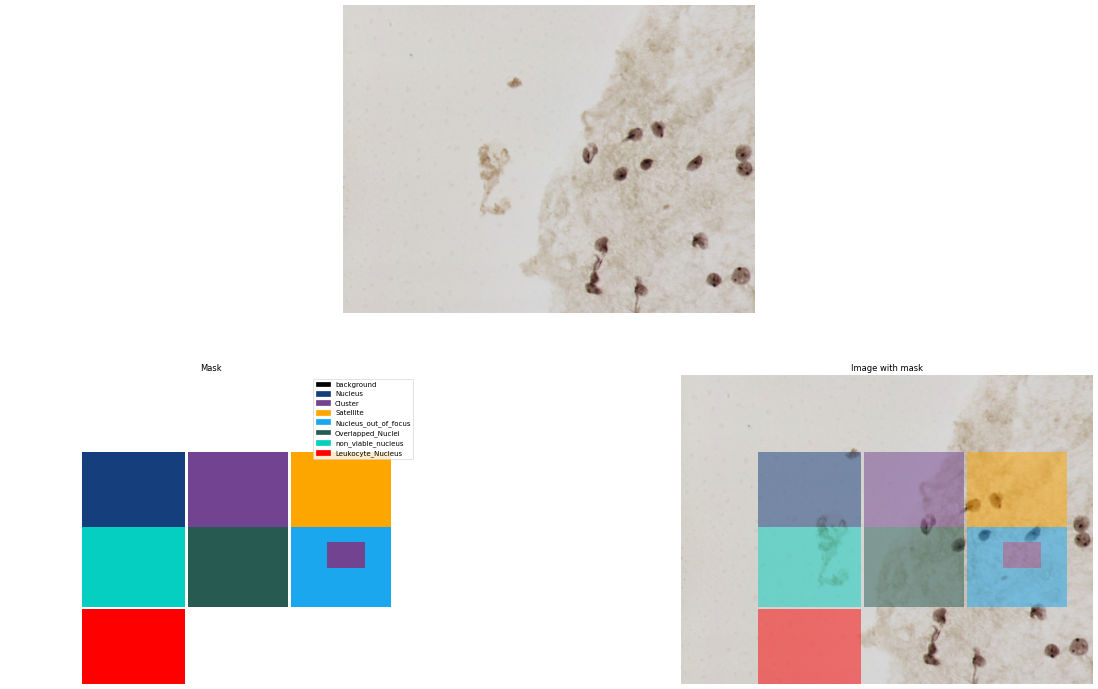

In [25]:
fig = plt.figure(figsize=(32, 18), dpi= 50)

positions = [(2,2,(1,2)), (2,2,3), (2,2,4)]
ax = [fig.add_subplot(nrows, ncols, plot_number) for nrows, ncols, plot_number in positions]

ax[0].imshow(img)
ax[0].set_axis_off()

plot.mask_with_color(msk, ax[1], ccagt_infos, colorized=False)
ax[1].legend(handles=handles)
ax[1].set_title('Mask')

ax[2].imshow(img)
plot.mask_with_color(msk, ax[2], ccagt_infos, colorized=False, alpha=0.5)
ax[2].set_title('Image with mask')

plt.show()